# COMP578 Data Mining Spring 2017
## Assignment 3

In this assignment, you will continue to work with the [Mammographic Mass Data Set](http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/).

The first column in that set, BI-RADS, is an evaluation of the radiology personnel based on the test readings.

Here is a quote from the description:
<p style="width: 90%;
    background-color: #EEEEEE;
    color: #5555AA;
    padding: 25px;
    margin: 1em;
    align: center;
    line-height: 100%;"> Each instance has an associated BI-RADS assessment ranging from 1 (definitely benign)
    to 5 (highly suggestive of malignancy) assigned in a double-review process by
    physicians. Assuming that all cases with BI-RADS assessments greater or equal
    a given value (varying from 1 to 5), are malignant and the other cases benign,
    sensitivities and associated specificities can be calculated. These can be an
    indication of how well a CAD system performs compared to the radiologists.</p>

In this assignment, you are to evaluate the use of linear regression to estimate BI-RADS based on the four predictors:
* Age
* Shape
* Margin
* Density

To achieve that, you will perform tests similar to shown in the lab for this block.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib notebook

In [2]:
url_data = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

## Columns: BI-RADS Assessment, Age, Shape, Margin, Density, Severity
names = ['BIRADS', 'Age', 'Shape','Margin','Density','Severity']
data = pd.read_csv(url_data, header=None, names=names, na_values='?')

data = data.interpolate(method='linear', axis=0, inplace=False)
data = data[((data['BIRADS'] - data['BIRADS'].mean()) / data['BIRADS'].std()).abs() < 3] #remove outliers from BI-RADS that were affecting output

### Task 1
##### 5 points

Fit the data using models built with individual predictors.

For each predictor, show a plot with with the scattered data and the regression curves for fitting with three models of order 1, 2, and 5.

In [3]:
regr = sklearn.linear_model.LinearRegression()


class ModelData: # each comparison (BI-RADS vs Age, Severity, etc)
    def __init__(self):
        self.thefit = []
        self.calc_RSS = 0
        self.calc_RSE = 0
        self.calc_RSQ = 0
        self.calc_FSTAT = 0
        self.coef = 0
        self.intercept = 0
    
         
birads = ModelData()
age = ModelData()
margin = ModelData()
shape = ModelData()
severity = ModelData()
density = ModelData()

col_to_var = {'BIRADS':birads,
              'Density':density,
              'Age':age, 
              'Margin':margin, 
              'Shape':shape, 
              'Severity':severity}

def modelfit(pred):
    ## METHOD 1 (scikitlearn)
    # prepare the data
    X = sklearn.preprocessing.scale(data[pred], with_mean=True, with_std=False).reshape(-1,1) # -1 - calculate the dimension implicitly
    y = data.BIRADS

    # fit the data (i.e., compute the coefficients beta_1 a.k.a. intercept_ and beta_2 a.k.a. coef_)
    fit = regr.fit(X,y)
    col_to_var[pred].coef = fit.coef_
    col_to_var[pred].intercept = fit.intercept_
    
    ## METHOD 2 (statsmodels)
    fit = smf.ols('BIRADS ~ '+pred,data).fit()
    
    col_to_var[pred].thefit = fit ## Save statsmodels fit for part 6
        
for pred in list(data):
    if pred != 'BIRADS':
        modelfit(pred)
        

/home/omar/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


<IPython.core.display.Javascript object>


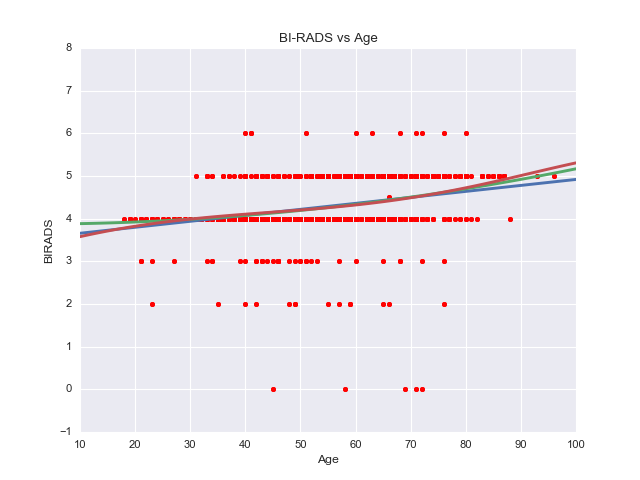

<IPython.core.display.Javascript object>


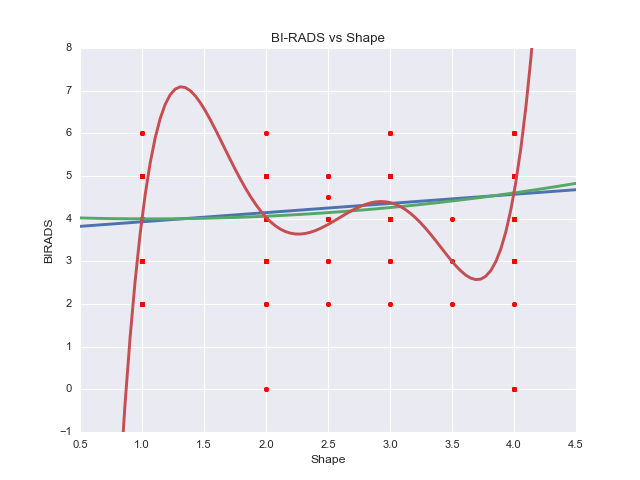

<IPython.core.display.Javascript object>


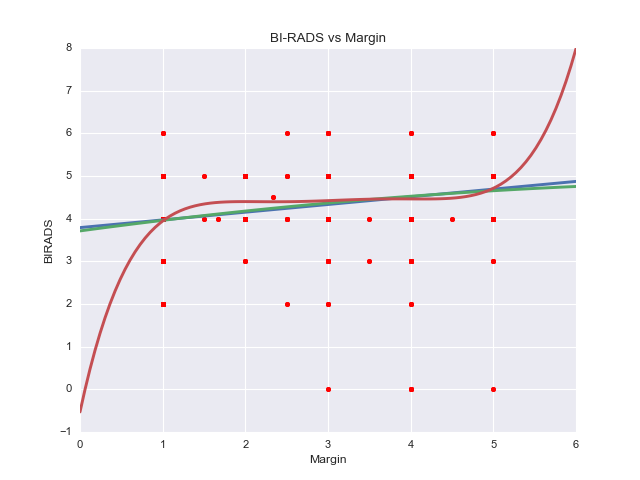

<IPython.core.display.Javascript object>


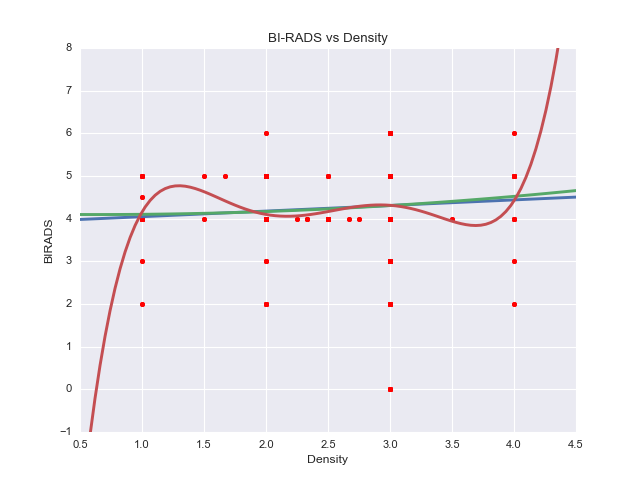

<IPython.core.display.Javascript object>


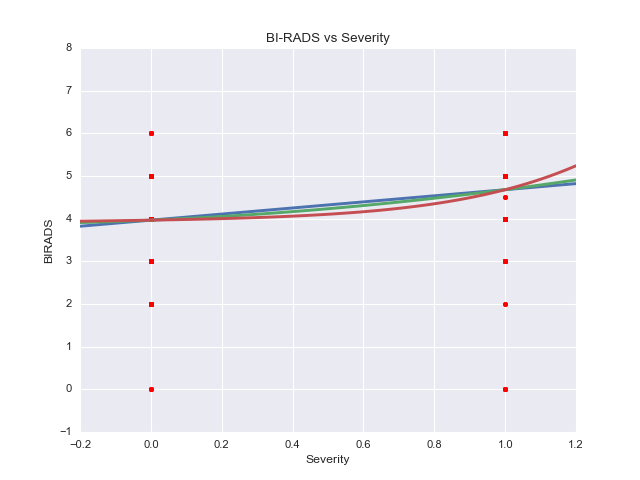

/home/omar/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/omar/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [4]:
def plotparams(pred):     
    plt.figure()
    plotreg(data[pred],1)
    plotreg(data[pred],2)
    plotreg(data[pred],5)
    
    plt.title('BI-RADS vs ' + pred)
    plt.show()

def plotreg(pred,ord):
    sns.regplot(pred, data.BIRADS, order=ord, ci=None, scatter_kws={'color':'r'})
    plt.ylim(-1,8)

for x in list(data):
    if x != 'BIRADS': # we don't want to plot birads vs birads
        plotparams(x)



### Task 2
##### 5 points

For each model obtained in Task 1, compute `p-value` for the coefficient, `RSE` (Residual Standard Error), $R^2$, and `F-statistic`.

In [5]:
import math

def findstats(pred):
    # create a fitter
    regr = sklearn.linear_model.LinearRegression()

    # prepare the data
    X = data[pred].values.reshape(-1,1)
    y = data.BIRADS
    
    p = 1
    
    regr.fit(X,y)

    BIRADS_pred = regr.predict(X)
    
    ##RSE
    n = data.BIRADS.size
    RSS = ((data.BIRADS - BIRADS_pred)**2).sum()
    RSE = math.sqrt(RSS/(n-2))

    ## F-Statistic
    TSS = ((data.BIRADS - data.BIRADS.mean())**2).sum()
    
    F_STAT = ((TSS-RSS)/p)/(RSS/(n-p-1)) #flipped rss and tss for positive values
        
    ##R-Squared
    R_SQ = (1 - RSS/TSS)
    
    col_to_var[pred].calc_RSS = RSS
    col_to_var[pred].calc_RSE = RSE
    col_to_var[pred].calc_RSQ = R_SQ
    col_to_var[pred].calc_FSTAT = (F_STAT)

    print('Predictor: ' + pred)
    print('Residual Standard Error: ' + str(RSE))
    print('Residual Sum of Squares: ' + str(RSS)) 
    print('R Squared: ' + str(R_SQ))
    print('F-Statistic: ' + str(F_STAT))
    print()
    
    return RSS
    
for pred in list(data):
    if pred != 'BIRADS':
        findstats(pred)


Predictor: Age
Residual Standard Error: 0.6762780112684066
Residual Sum of Squares: 438.1431666870947
R Squared: 0.08247823125974962
F-Statistic: 86.1169165014209

Predictor: Shape
Residual Standard Error: 0.6542604897188694
Residual Sum of Squares: 410.07840329407344
R Squared: 0.14124904706943953
F-Statistic: 157.57372568932098

Predictor: Margin
Residual Standard Error: 0.6484346827791038
Residual Sum of Squares: 402.80790124194175
R Squared: 0.15647430769130743
F-Statistic: 177.70933136369118

Predictor: Density
Residual Standard Error: 0.7041999896279949
Residual Sum of Squares: 475.0699251256012
R Squared: 0.005149386963202551
F-Statistic: 4.958646701427548

Predictor: Severity
Residual Standard Error: 0.6094996884967331
Residual Sum of Squares: 355.88729572595486
R Squared: 0.2547314077367293
F-Statistic: 327.4426041096076



### Task 3
##### 5 points

For each model obtained in Task 1, draw a plot showing a 3D RSS surface that captures the relationship between the RSS and the coefficients $\beta_0$ (intercept) and $\beta_1$ (coefficient for the predictor).

4.2953125
[ 0.01401942]


<IPython.core.display.Javascript object>


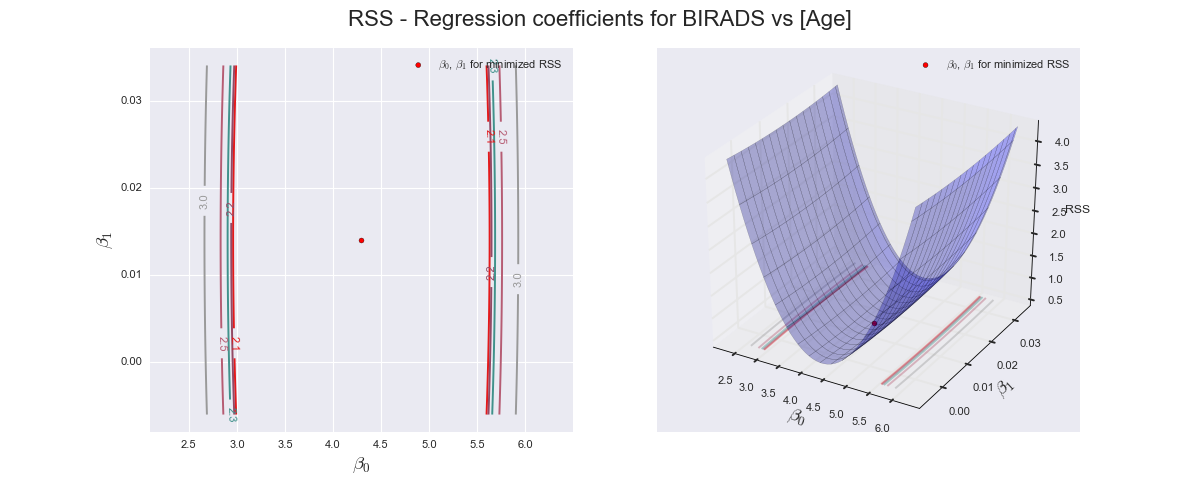

4.2953125
[ 0.21469727]


<IPython.core.display.Javascript object>


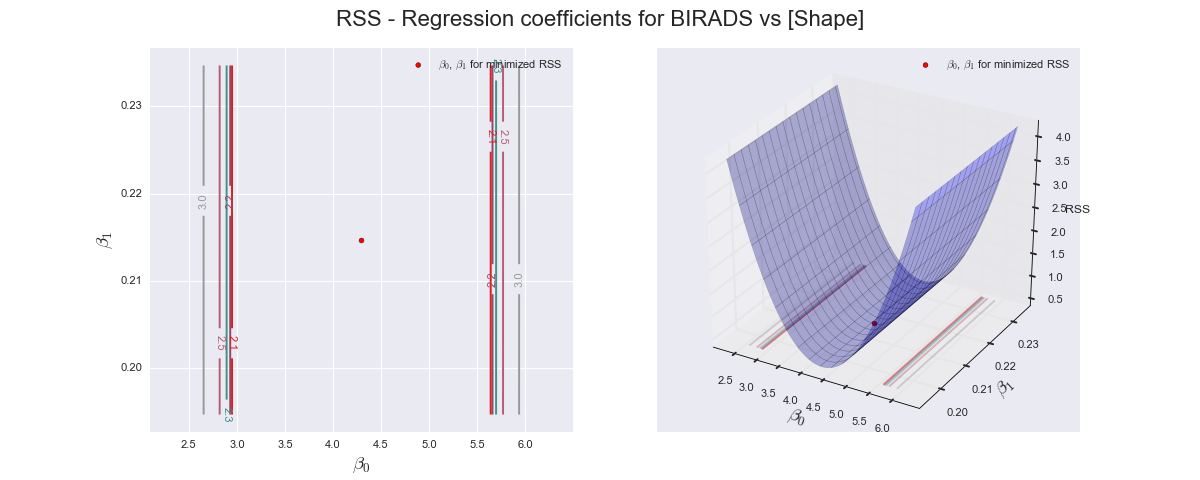

4.2953125
[ 0.18037546]


<IPython.core.display.Javascript object>


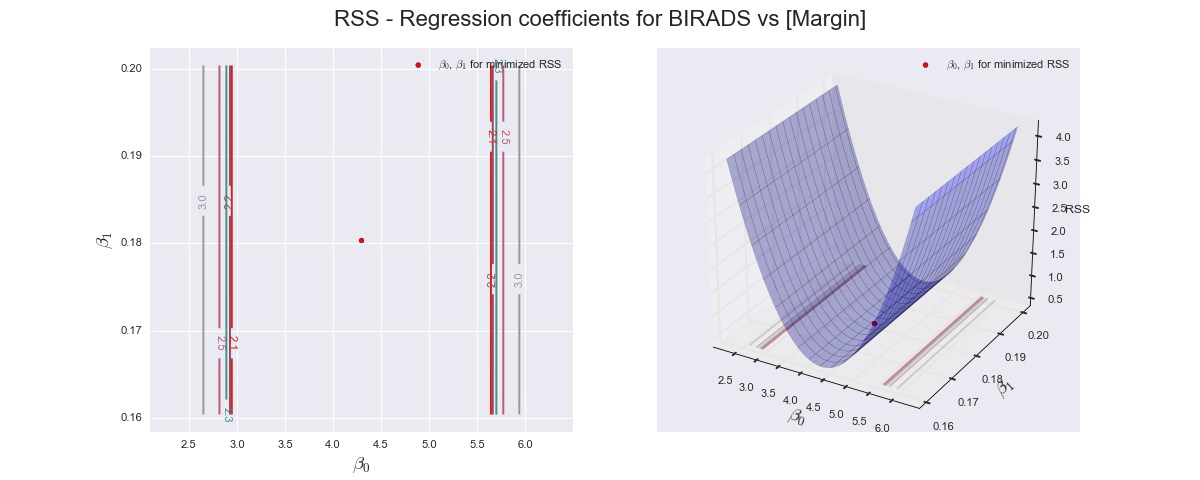

4.2953125
[ 0.13111106]


<IPython.core.display.Javascript object>


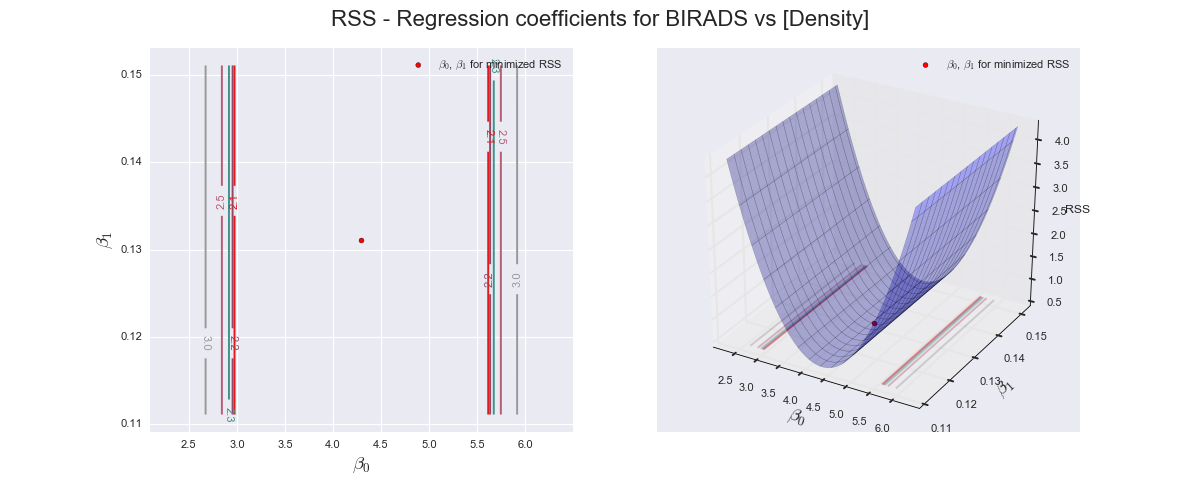

/home/omar/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


4.2953125
[ 0.71393777]


<IPython.core.display.Javascript object>


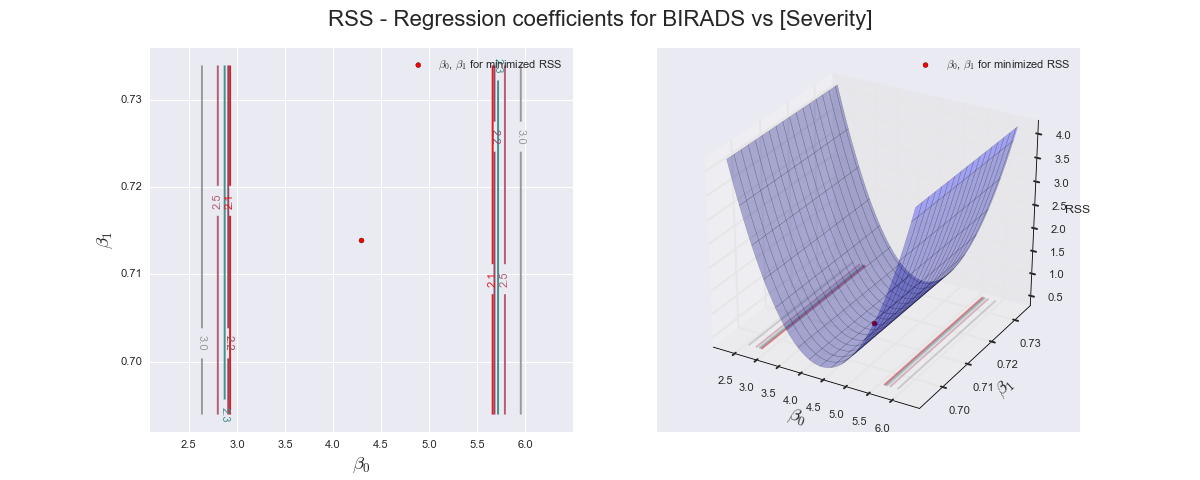

In [6]:
def plotloop(data,pred):
    # create a fitter
    regr = sklearn.linear_model.LinearRegression()

    # prepare the data
    X = sklearn.preprocessing.scale(data[pred], with_mean=True, with_std=False).reshape(-1,1) # -1 - calculate the dimension implicitly
    # X = advertising.TV.reshape(-1,1) # this would get us the result as in the book, but the plots would not be as nice
    y = data['BIRADS']

    # fit the data (i.e., compute the coefficients beta_1 a.k.a. intercept_ and beta_2 a.k.a. coef_)
    regr.fit(X,y)

    print(regr.intercept_) # beta_0
    print(regr.coef_) # beta_1

    # Create grid coordinates for plotting
    beta0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
    beta1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
    xx, yy = np.meshgrid(beta0, beta1, indexing='xy')
    Z = np.zeros((beta0.size, beta1.size))

    # Calculate Z-values (RSS - Residual Sum of Squares) based on grid of coefficients
    for (i,j),v in np.ndenumerate(Z): # generates (index, value)
        # xx[i,j] = beta_0, yy[i,j] = beta_1
        Z[i,j] =((y - (xx[i,j]+X.flatten()*yy[i,j]))**2).sum()/1000 # scale down

    # Minimimal RSS (using the solution: intercept a.k.a beta_0 and slope a.k.a beta_1)
    min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    min_rss = np.sum((regr.intercept_+regr.coef_*X - y.reshape(-1,1))**2)/1000 # scale down
    min_rss

    fig = plt.figure(figsize=(15,6))
    fig.suptitle('RSS - Regression coefficients for BIRADS vs [' + str(pred) + ']', fontsize=20)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    # Left plot
    CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS) # just one point (red)
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

    # Right plot
    ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
    ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
                alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS) # again, just one point
    ax2.set_zlabel('RSS')
    ax2.set_zlim(Z.min(),Z.max())
    # no y limit set. plots came out at odd scale, so I let the program set the scale
    
    # settings common to both plots
    for ax in fig.axes:
        ax.set_xlabel(r'$\beta_0$', fontsize=17)
        ax.set_ylabel(r'$\beta_1$', fontsize=17)
        #again, no y-limit set.
        ax.legend()
        
for pred in list(data):
    if pred != 'BIRADS':
        plotloop(data,pred)

### Task 4
##### 10 points

Use the **forward selection** approach to evaluate models constructed with increasing number of predictors.

Recall:

<p style="width: 90%;
    background-color: #EEEEEE;
    color: #5555AA;
    padding: 25px;
    margin: 1em;
    align: center;
    line-height: 100%;">We begin with the null model; i.e., a model that contains an intercept but no predictors. We then fit p simple linear regressions and add to the null model the variable that results in the lowest RSS. We then add to that model the variable that results variable selection in the lowest RSS for the new two-variable model. This approach is continued until some stopping rule is satisfied.</p>

> Note that Task 1 realizes the first step in the selection. So the starting point here is to select the predictor with used in the model with the lowest RSS from Task 1, and then fit the data into a new model for the selected predictor with another one. Then you need to repeat that for the remaining predictors, and when you have models for each pair, you select the best one again. Then you work on adding the third predictor; and so on. The stopping condition is to add all predictors.

In [7]:
# Create dictionary of RSS to predictor, then dataframe for sorting
RSSdict = {}
for key in col_to_var:
    if key != 'BIRADS':
        RSSdict[col_to_var[key].calc_RSS] = key

RSS_df = pd.DataFrame.from_dict(RSSdict,orient='index')
RSS_df.sort_index(inplace=True)
RSS_df.reset_index(inplace=True)

# Forward build model iteratively
thestring = 'BIRADS ~ '

def stringBuilder(thestring, pred):
    if thestring == 'BIRADS ~ ': #first case
        thestring = thestring + pred
    else:
        thestring = thestring + ' + ' + pred
    
    return thestring

def forwardselect(thestring):
    for_sel = smf.ols(thestring,data).fit()
    print('Summary for: ' + thestring)
    print (for_sel.summary())
    print()
    print()
    
    
print ('Predictors Sorted by RSS')   
print (RSS_df)
print()
print()

for x in range (0,5): #for pred in list(data):
    pred = RSS_df[0].loc[x]
    if pred != 'BIRADS':
        thestring = stringBuilder(thestring,pred)
        forwardselect(thestring)




Predictors Sorted by RSS
        index         0
0  355.887296  Severity
1  402.807901    Margin
2  410.078403     Shape
3  438.143167       Age
4  475.069925   Density


Summary for: BIRADS ~ Severity
                            OLS Regression Results                            
Dep. Variable:                 BIRADS   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     327.4
Date:                Wed, 15 Feb 2017   Prob (F-statistic):           3.50e-63
Time:                        17:05:34   Log-Likelihood:                -885.87
No. Observations:                 960   AIC:                             1776.
Df Residuals:                     958   BIC:                             1785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
        

### Task 5
##### 10 points

Use the **backward selection** approach to evaluate models constructed with descreasing number of predictors.

Recall:

<p style="width: 90%;
    background-color: #EEEEEE;
    color: #5555AA;
    padding: 25px;
    margin: 1em;
    align: center;
    line-height: 100%;">We start with all variables in the model, and remove the variable with the largest p-value; i.e., the variable that is the least statistically significant. The new (p−1)-variable model is fit, and the variable with the largest p-value is removed. This procedure continues until a stopping rule is reached. For instance, we may stop when all remaining variables have a p-value below some threshold.</p>

> Note that p-values are used in this method, and not RSS as in the forward selection. The stopping condition is one a model with one predictor. Is it the same that had the highest RSS in Task 1?

In [8]:
data_list = ['Age','Margin','Severity','Density','Shape']

the_string = 'BIRADS ~ '

def stringbuilder(the_string,data_list):
    for pred in data_list:
        if the_string == 'BIRADS ~ ':
            the_string = the_string + pred
        else:
            the_string = the_string + ' + ' + pred
    return the_string

def summaryoutput(the_string,data):
    fit = smf.ols(the_string,data).fit()
    print(the_string)
    print(fit.summary())
    print()
    print()
    print()
    
    return fit
        
the_string = stringbuilder(the_string,data_list)
print('ALL PREDICTORS')
fit = summaryoutput(the_string,data)

#assign pvalues to dataframe and sort descending
fitframe = pd.DataFrame(fit.pvalues)
fitframe.sort(columns=0, axis=0,ascending=False,inplace=True)
fitframe.index.map(str)
fitframe.drop(fitframe.index[-1],inplace=True) #drop 'Intercept' row

print('REMOVE PREDICTORS BASED ON P-VALUE (LARGEST FIRST)')
for x in range (0,5):
    data_list = list(fitframe.index.values[x:]) 
    the_string = 'BIRADS ~ '
    the_string = stringbuilder(the_string, data_list)
    summaryoutput(the_string,data)
   
 

ALL PREDICTORS
BIRADS ~ Age + Margin + Severity + Density + Shape
                            OLS Regression Results                            
Dep. Variable:                 BIRADS   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     73.79
Date:                Wed, 15 Feb 2017   Prob (F-statistic):           2.17e-65
Time:                        17:05:34   Log-Likelihood:                -870.05
No. Observations:                 960   AIC:                             1752.
Df Residuals:                     954   BIC:                             1781.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------

/home/omar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


#### Observation:
While the order of predictors was not a direct inverse of the forward selection, the final remaining predictor was Severity, the first predictor in the forward selection model.

### Task 6
##### 5 points

Build a model that includes all predictors and all combinations of their correlations (individual, pair-wise, triplets, and quad).

Compute RSE (Residual Standard Error), $R^2$, and F-statistic.

Also compute **variance inflation factors (VIF) for all coefficients. You will need to use the coefficients from the model created here, and the models created in Task 1.

In [9]:
from itertools import combinations
 
#build string from all possible combinations of correlations
data_list = ['Age','Margin','Severity','Density','Shape']

the_string = 'BIRADS ~ '
for x in range (0,len(data_list)):
    if x == 0:
        the_string = the_string + data_list[x]
    else:
        the_string = the_string + ' + ' + data_list[x]

combo_list = list(combinations(data_list,2))
for x in range (0,len(combo_list)):
    pair_string = str(combo_list[x][0]) + "*" + str(combo_list[x][1])
    the_string = the_string + ' + ' + pair_string
    
combo_list = list(combinations(data_list,3))
for x in range (0,len(combo_list)):
    trip_string = str(combo_list[x][0]) + "*" + str(combo_list[x][1]) + "*" + str(combo_list[x][2])
    the_string = the_string + ' + ' + trip_string
    
combo_list = list(combinations(data_list,4))
for x in range (0,len(combo_list)):
    quad_string = str(combo_list[x][0]) + "*" + str(combo_list[x][1]) + "*" + str(combo_list[x][2]) + '*' + str(combo_list[x][3])
    the_string = the_string + ' + ' + quad_string
    

fit_all = smf.ols(the_string,data).fit()
RSE_all = fit.ssr/(fit_all.df_resid) #RSS divided by degrees of freedom (n - p - 1)

print('The Model: ' + the_string)
print()
print('Results for Model (All Combinations)')
print('Residual Standard Error (RSE): ' + str(RSE_all))
print('R-Squared: ' + str(fit_all.rsquared))
print('F-statistic: ' + str(fit_all.fvalue))

The Model: BIRADS ~ Age + Margin + Severity + Density + Shape + Age*Margin + Age*Severity + Age*Density + Age*Shape + Margin*Severity + Margin*Density + Margin*Shape + Severity*Density + Severity*Shape + Density*Shape + Age*Margin*Severity + Age*Margin*Density + Age*Margin*Shape + Age*Severity*Density + Age*Severity*Shape + Age*Density*Shape + Margin*Severity*Density + Margin*Severity*Shape + Margin*Density*Shape + Severity*Density*Shape + Age*Margin*Severity*Density + Age*Margin*Severity*Shape + Age*Margin*Density*Shape + Age*Severity*Density*Shape + Margin*Severity*Density*Shape

Results for Model (All Combinations)
Residual Standard Error (RSE): 0.370671656625
R-Squared: 0.301850939359
F-statistic: 13.3887130258


In [10]:
print('Variance Inflation Factors')

for key in col_to_var:
    if key != 'BIRADS':
        print('VIF for [' + key + ']: ' + str((1/(1-(col_to_var[key].thefit.rsquared)))))

print('VIF for [All Combinations/Correlations]: ' + str((1/(1-fit_all.rsquared))))


Variance Inflation Factors
VIF for [Shape]: 1.16448196836
VIF for [Margin]: 1.18550034589
VIF for [Density]: 1.0051760404
VIF for [Severity]: 1.34179812538
VIF for [Age]: 1.08989239718
VIF for [All Combinations/Correlations]: 1.43235887059
